In [2]:
%matplotlib notebook

In [66]:
import random
import numpy as np
import graph_tool as gt
from graph_tool import Graph, GraphView
from graph_tool.topology import random_spanning_tree, isomorphism
from graph_tool.generation import complete_graph, lattice
from graph_tool.draw import sfdp_layout, graph_draw
from scipy.stats import entropy, pearsonr
from matplotlib import pyplot as plt

from tqdm import tqdm

from cascade_generator import si, observe_cascade
from graph_helpers import (extract_steiner_tree, filter_graph_by_edges, extract_edges,
                           extract_nodes, gen_random_spanning_tree, load_graph_by_name, GraphWrapper)
from math_helpers import hellinger_distancee
from core import det_score_of_steiner_tree

from viz_helpers import lattice_node_posattice_node_pos

In [47]:
random.seed(1234)
np.random.seed(1234)
shape = (10, 10)
graph_name = 'dolphin'
g = load_graph_by_name(graph_name)


In [72]:
load_graph_by_name('karate')


<GraphView object, undirected, with 34 vertices and 78 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7f4fcdab52e8, at 0x7f4fcda90390>, False), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7f4fcdab52e8, at 0x7f4fcda904e0>, False) at 0x7f4fcdab52e8>

In [70]:
g

<GraphView object, undirected, with 62 vertices and 159 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7f4fccbc5550, at 0x7f4fccbc57f0>, False), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7f4fccbc5550, at 0x7f4fccbc5898>, False) at 0x7f4fccbc5550>

In [48]:
s, c, t = si(g, 0.1)
o = observe_cascade(c, s, 0.2)
print(o)

[15 20 11  2 51 16  7]


In [49]:
sample_count = 5000
steiner_trees = []
for _ in tqdm(range(sample_count)):
    rand_t = gen_random_spanning_tree(g)
    st = extract_steiner_tree(rand_t, o)
    steiner_trees.append(st)
det_scores = [det_score_of_steiner_tree(st, g) for st in tqdm(steiner_trees)]
    

100%|██████████| 5000/5000 [02:48<00:00, 29.73it/s]


In [50]:
tree_sizes = np.array([st.num_edges() for st in steiner_trees])
det_scores = np.array(det_scores)
energy_scores = np.exp(-tree_sizes)

In [51]:
# print("pearson correlation after log: {:.5f}".format(pearsonr(np.log(det_scores), np.log(energy_scores))[0]))
print("pearson correlation: {:.5f}".format(pearsonr(det_scores, energy_scores)[0]))

pearson correlation: 0.67645


In [52]:
from numpy import random
m = 500
real_scores = np.exp(-tree_sizes)
sampling_importance = real_scores / np.array(det_scores)
sampling_importance /= sampling_importance.sum()
resampled_ids = random.choice(np.arange(len(steiner_trees)), m, replace=False, p=sampling_importance)
steiner_trees_resampled = [steiner_trees[i] for i in resampled_ids]

In [53]:
tree_sizes_resampled = np.array([st.num_edges() for st in steiner_trees_resampled])

<IPython.core.display.Javascript object>


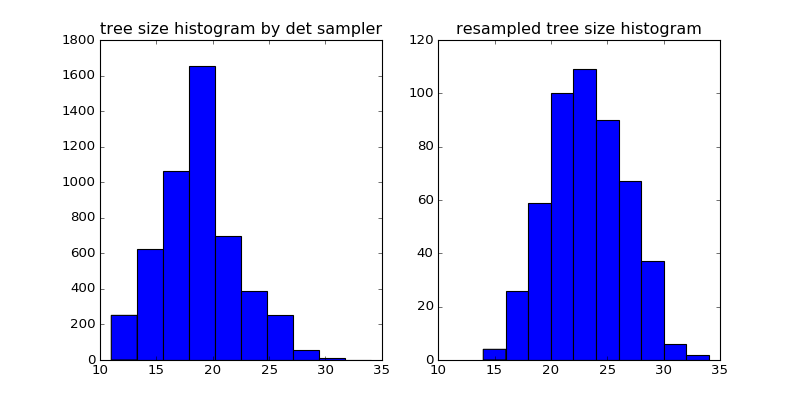

(array([   4.,   26.,   59.,  100.,  109.,   90.,   67.,   37.,    6.,    2.]),
 array([ 14.,  16.,  18.,  20.,  22.,  24.,  26.,  28.,  30.,  32.,  34.]),
 <a list of 10 Patch objects>)

In [54]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('tree size histogram by det sampler')
ax[0].hist(tree_sizes)
ax[1].set_title('resampled tree size histogram')
ax[1].hist(tree_sizes_resampled)

In [58]:
t2det = {}
for s, t in zip(det_scores, steiner_trees):
    t2det[GraphWrapper(t)] = s


In [59]:
t2energy = {}
for s, t in zip(energy_scores, steiner_trees):
    t2energy[GraphWrapper(t)] = s


In [69]:
len(t2det)

5000

In [62]:
ts = list(t2det.keys())
det_scores = np.array([t2det[t] for t in ts])
energy_scores = np.array([t2energy[t] for t in ts])

In [63]:
det_probas = det_scores / det_scores.sum()
energy_probas = energy_scores / energy_scores.sum()

In [64]:
hellinger_distance(det_probas, energy_probas)

0.39462996180409454

<IPython.core.display.Javascript object>


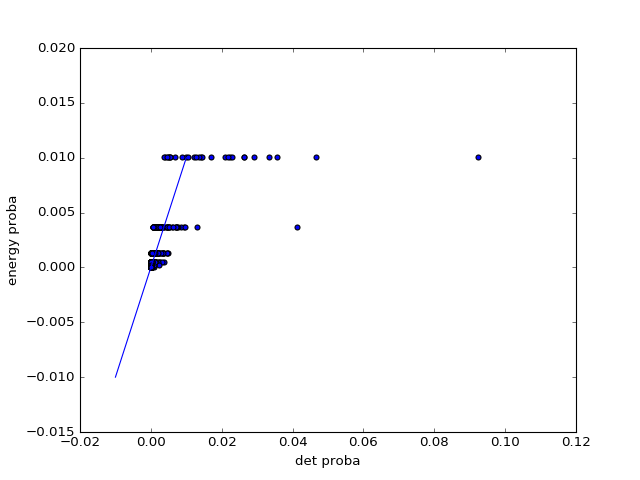

In [65]:
fig = plt.figure()
plt.scatter(det_probas, energy_probas)
plt.hold(True)
plt.plot(np.linspace(-0.01, 0.01, 100), np.linspace(-0.01, 0.01, 100))
plt.xlabel('det proba')
plt.ylabel('energy proba')

<IPython.core.display.Javascript object>


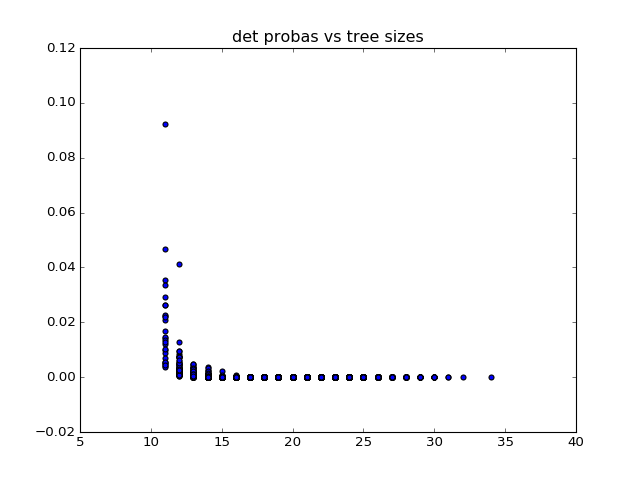

In [68]:
plt.figure()
sizes = [t._g.num_edges() for t in ts]
plt.scatter(sizes, det_probas)
plt.title('det probas vs tree sizes')